# Rapid Searching of Synthon Spaces

**Note** this is a guest post written by Dave Cosgrove (GitHub: @DavidACosgrove).

There are a number of combinatorial libraries now available offering compounds made to order from a vast array of possibilities, such as [Enamine's REAL](https://enamine.net/compound-collections/real-compounds/real-database) or [ChemSpace's FreedomSpace](https://chem-space.com/compounds/freedom-space).  The enumerated versions of these databases run to billions of compounds making them expensive and difficult to manage and search.  Several groups have proposed algorithms for the rapid search of these libraries in synthon rather than enumerated form (e.g. [Spacelight](https://doi.org/10.1021/acs.jcim.0c00850) and [Liphardt and Sander](https://doi.org/10.1021/acs.jcim.3c00290)).  This blogpost describes the implementation of substructure and similarity search methods based on the ideas in the latter.

The examples use the FreedomSpace 2023 library of some 9 billion compounds.  The new module, available starting in the 2024.09.3 release, is rdSynthonSpaceSearch.  Timings are from my Mac mini M4 Pro (very nice, you should get one!).

> Obligatory new functionality disclaimer: this is completely new RDKit functionality and is still a bit experimental. The API and results may change over the next couple of releases as we do more testing and get more feedback from the community

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdSynthonSpaceSearch, rdFingerprintGenerator
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D, rdDepictor
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit import rdBase
import time

rdDepictor.SetPreferCoordGen(True)
print(rdBase.rdkitVersion)

2024.09.3


Load the library and print some information about it.

In [2]:
start = time.perf_counter()
synthonspace = rdSynthonSpaceSearch.SynthonSpace()
synthonspace.ReadTextFile("/Users/david/Projects/FreedomSpace/2023-05_Freedom_synthons.txt")
print(f"Number of reactions : {synthonspace.GetNumReactions()}")
print(f"Number of products : {synthonspace.GetNumProducts()}")
print(f"Time to load : {time.perf_counter() - start:4.2f} seconds.")

Number of reactions : 10
Number of products : 9360696185
Time to load : 26.47 seconds.


There's a binary format that loads much more quickly.

In [3]:
synthonspace.WriteDBFile("/Users/david/Projects/FreedomSpace/2023-05_Freedom_synthons.spc")
start = time.perf_counter()
synthonspace.ReadDBFile("/Users/david/Projects/FreedomSpace/2023-05_Freedom_synthons.spc")
print(f"Time to load : {time.perf_counter() - start:4.2f} seconds.")

Time to load : 4.47 seconds.


If you want more information about the library:

In [4]:
synthonspace.Summarise()

Read from file /Users/david/Projects/FreedomSpace/2023-05_Freedom_synthons.spc
Number of reactions : 10
Reaction name a1
  Synthon set 0 has 18662 synthons
  Synthon set 1 has 16838 synthons
Reaction name a2
  Synthon set 0 has 18540 synthons
  Synthon set 1 has 1503 synthons
Reaction name a3
  Synthon set 0 has 492 synthons
  Synthon set 1 has 4700 synthons
Reaction name a4
  Synthon set 0 has 17547 synthons
  Synthon set 1 has 4539 synthons
Reaction name a5
  Synthon set 0 has 6420 synthons
  Synthon set 1 has 810 synthons
Reaction name a6
  Synthon set 0 has 5126 synthons
  Synthon set 1 has 11636 synthons
Reaction name a7
  Synthon set 0 has 320 synthons
  Synthon set 1 has 1148 synthons
  Synthon set 2 has 9608 synthons
Reaction name a77
  Synthon set 0 has 80 synthons
  Synthon set 1 has 5890 synthons
  Synthon set 2 has 8366 synthons
Reaction name a8
  Synthon set 0 has 10060 synthons
  Synthon set 1 has 34 synthons
Reaction name a80
  Synthon set 0 has 20 synthons
  Synthon set

## Substructure Searching

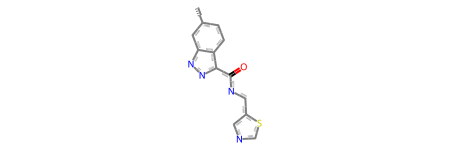

In [5]:
qmol = Chem.MolFromSmarts("c12ccc(C)cc1[nH]nc2C(=O)NCc1cncs1")
qmol

In [6]:
start = time.perf_counter()
results = synthonspace.SubstructureSearch(qmol)
hits = results.GetHitMolecules()
hit_names = [m.GetProp("_Name") for m in hits]
print(f"Time to search : {time.perf_counter() - start:4.2f} seconds.")
print(f"Number of hits : {len(hits)}")

Time to search : 0.33 seconds.
Number of hits : 108


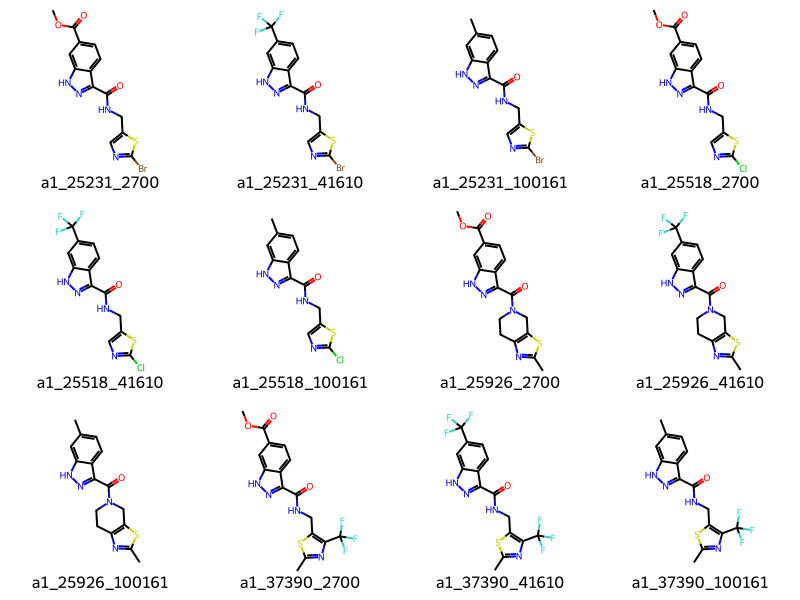

In [7]:
if hits:
    img = Draw.MolsToGridImage(hits[:12], legends=hit_names[:12], molsPerRow=4)
else:
    img = "No Hits"
img

The molecule names are made up of the reaction name and the synthons for that reaction. So the first hit above is made from synthons 2700 and 25231 and reaction a1.

Complex SMARTS queries are supported, though can take a little longer to run.  The maximum number of hits to be returned is capped at 1000 by default.  You can obtain an upper bound on the maximum number of hits possible; there may be fewer hits than this in practice, as duplicate matches are counted but not returned and for other more subtle reasons.

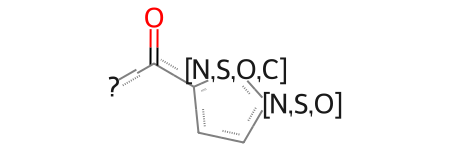

In [8]:
qmol = Chem.MolFromSmarts("c1c[n,s,o][n,s,o,c]c1C(=O)[$(N1CCCCC1),$(N1CCCC1)]")
qmol

In [9]:
start = time.perf_counter()
results = synthonspace.SubstructureSearch(qmol)
hits = results.GetHitMolecules()
hit_names = [m.GetProp("_Name") for m in hits]
print(f"Time to search : {time.perf_counter() - start:4.2f} seconds.")
print(f"Number of hits : {len(hits)}")
print(f"Maximum number of hits possible : {results.GetMaxNumResults}")

Time to search : 0.19 seconds.
Number of hits : 1000
Maximum number of hits possible : 2358187


You can control the number of hits returned, and also get a random sample of the hits, rather than the first N in the list:

Time to search : 0.13 seconds.
Number of hits : 12
Maximum number of hits possible : 2358187


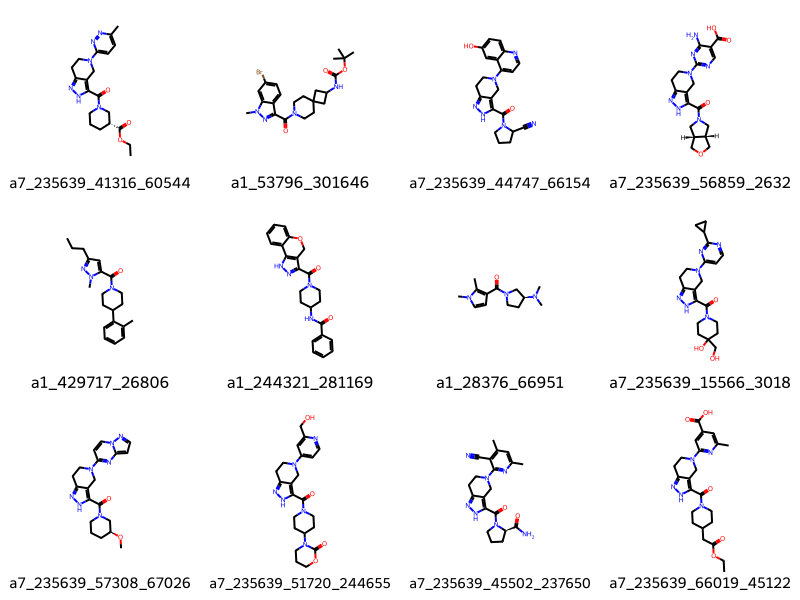

In [10]:
params = rdSynthonSpaceSearch.SynthonSpaceSearchParams()
params.maxHits = 12
params.randomSample = True
start = time.perf_counter()
results = synthonspace.SubstructureSearch(qmol, params)
hits = results.GetHitMolecules()
hit_names = [m.GetProp("_Name") for m in hits]
print(f"Time to search : {time.perf_counter() - start:4.2f} seconds.")
print(f"Number of hits : {len(hits)}")
print(f"Maximum number of hits possible : {results.GetMaxNumResults}")
Draw.MolsToGridImage(hits[:12], legends=hit_names[:12], molsPerRow=4)

Having looked at the first 1000 hits, you might want to get the next set in the list.  Here we get the 1000 starting at 2000.

Time to search : 0.19 seconds.
Number of hits : 1000


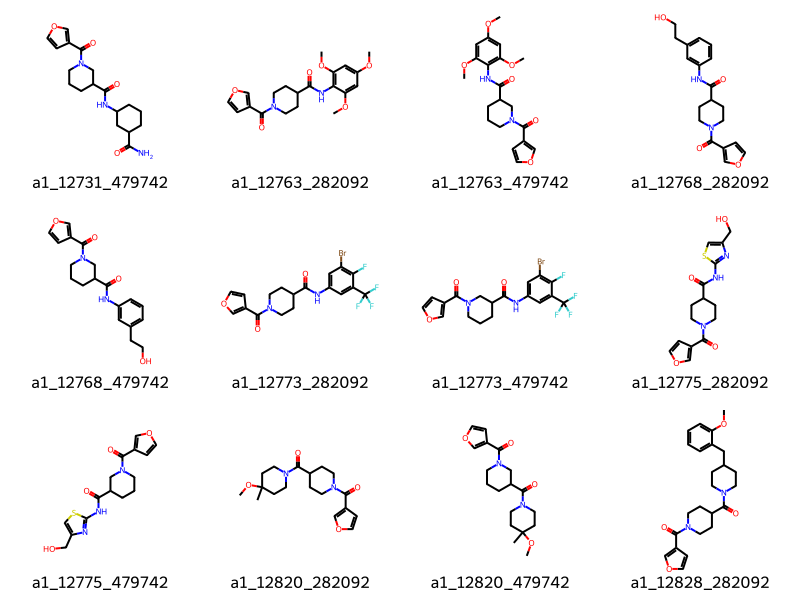

In [11]:
params = rdSynthonSpaceSearch.SynthonSpaceSearchParams()
params.maxHits = 1000
params.hitStart = 2000
start = time.perf_counter()
results = synthonspace.SubstructureSearch(qmol, params)
hits = results.GetHitMolecules()
hit_names = [m.GetProp("_Name") for m in hits]
print(f"Time to search : {time.perf_counter() - start:4.2f} seconds.")
print(f"Number of hits : {len(hits)}")
Draw.MolsToGridImage(hits[:12], legends=hit_names[:12], molsPerRow=4)

It is possible to check the upper bound on the number of hits without building them, just to get an idea of whether you need to refine the search or not.

In [12]:
qmol = Chem.MolFromSmarts("c12ccc(C)cc1[nH]nc2C(=O)NCc1cncs1")
params = rdSynthonSpaceSearch.SynthonSpaceSearchParams()
params.buildHits = False
results = synthonspace.SubstructureSearch(qmol, params)
hits = results.GetHitMolecules()
print(f"Number of hits : {len(hits)}")
print(f"Maximum number of hits possible : {results.GetMaxNumResults}")

Number of hits : 0
Maximum number of hits possible : 108


## Similarity Searching
Any of the RDKit fingerprint generators can be used, although the similarity metric is hard-coded as Tanimoto on a hashed fingerprint.  The search structure is [Osimertinib](https://en.wikipedia.org/wiki/Osimertinib) which is paying my pension so deserves acknowledgement.  Similarity values are returned in the property "Similarity" on each molecule.  If the binary file doesn't contain fingerprints, they will need to be generated.  This can be done ahead of time or it will be done as part of the first search.

[11:01:56] Building the fingerprints may take some time.


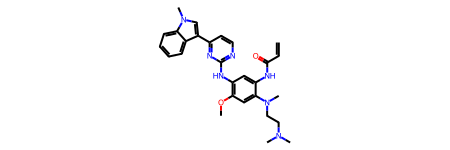

In [13]:
fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=2048)
synthonspace.BuildSynthonFingerprints(fpgen)
qmol = Chem.MolFromSmiles("C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(OC)cc1N(C)CCN(C)C")
qmol

Time to search : 20.29 seconds.
Number of hits : 1000
Maximum number of hits possible : 35911098


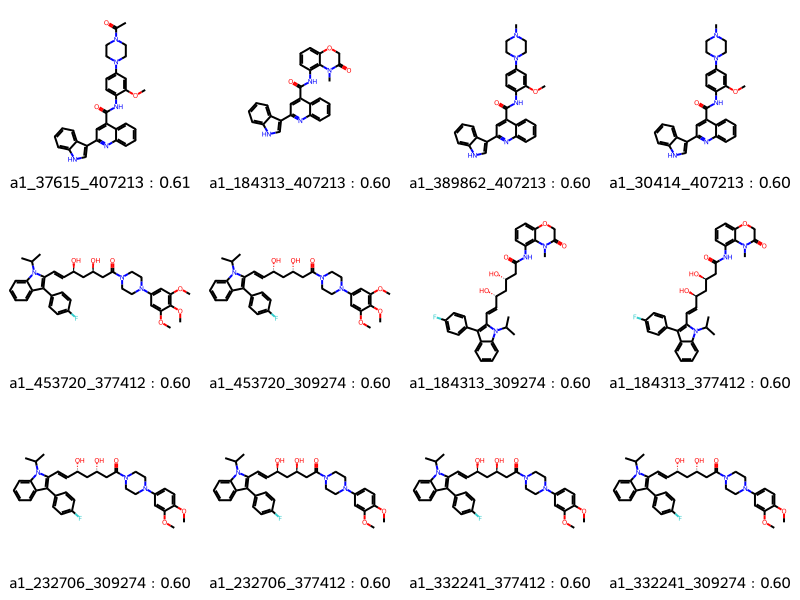

In [14]:
start = time.perf_counter()
results = synthonspace.FingerprintSearch(qmol, fpgen)
hits = results.GetHitMolecules()
hit_names = [f'{m.GetProp("_Name")} : {float(m.GetProp("Similarity")):4.2f}' for m in hits]
print(f"Time to search : {time.perf_counter() - start:4.2f} seconds.")
print(f"Number of hits : {len(hits)}")
print(f"Maximum number of hits possible : {results.GetMaxNumResults}")
Draw.MolsToGridImage(hits[:12], legends=hit_names[:12], molsPerRow=4)

The extra runtime is due to 2 factors.  The first is that osimertinib is a largish molecule, so many fragments are generated that all need to be compared with the synthons.  The second is that the screenout by fingerprint is less efficient, as you can see from the fact that 35911098 hits were possible having passed the initial fragment screening, although many of those won't make the similarity cutoff when the potential hit molecule is built and checked.

The similarity cutoff can be raised from the default 0.5 however this can result in large search times if there are few hits that meet the threshold - it may have to check all 35911098 potential hits.  Note that in the search below we take a random sample of the results, so the hits are not the same as above.

Time to search : 15.84 seconds.
Number of hits : 12
Maximum number of hits possible : 3925204


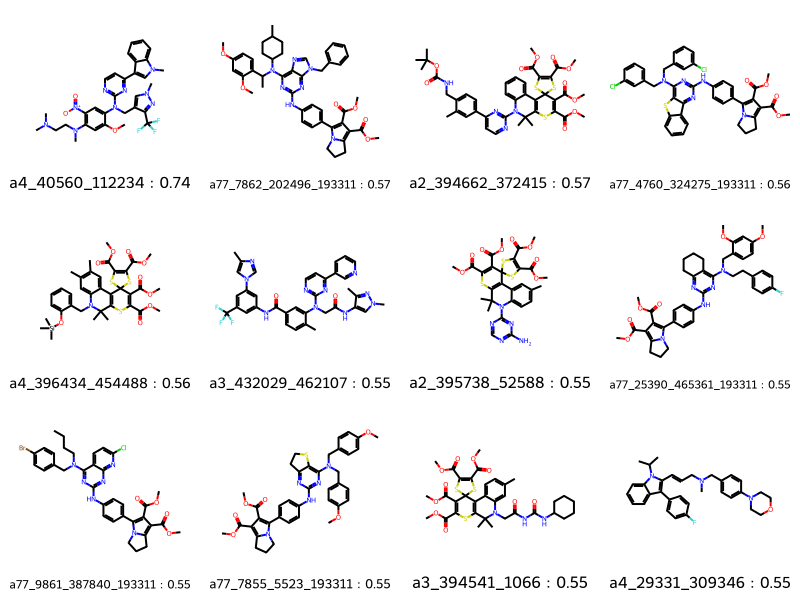

In [15]:
params = rdSynthonSpaceSearch.SynthonSpaceSearchParams()
params.maxHits = 12
params.randomSample = True
params.similarityCutoff = 0.55
start = time.perf_counter()
results = synthonspace.FingerprintSearch(qmol, fpgen, params)
hits = results.GetHitMolecules()
hit_names = [f'{m.GetProp("_Name")} : {float(m.GetProp("Similarity")):4.2f}' for m in hits]
print(f"Time to search : {time.perf_counter() - start:4.2f} seconds.")
print(f"Number of hits : {len(hits)}")
print(f"Maximum number of hits possible : {results.GetMaxNumResults}")
Draw.MolsToGridImage(hits[:12], legends=hit_names[:12], molsPerRow=4)

Tanimoto similarities between small molecules with sparsely populated fingerprints are known to be be lower and more granular than similiarties for larger entities.  This is relevant because the search starts by comparing fragments from the query molecule with synthons in the database.  Only synthons that match the fragment within the cutoff are considered as a basis for a hit.  There is a parameter that lowers the similarity cutoff for the fragment comparison compared to the global cutoff, which defaults to 0.1.  Thus, if your similarityCutoff is set to 0.5, synthons are considered a match to a fragment if their Tanimoto similarities are above 0.4.  If you want a faster search and don't mind possibly missing some hits, you can lower that difference.

Time to search : 15.74 seconds.
Number of hits : 12
Maximum number of hits possible : 690134


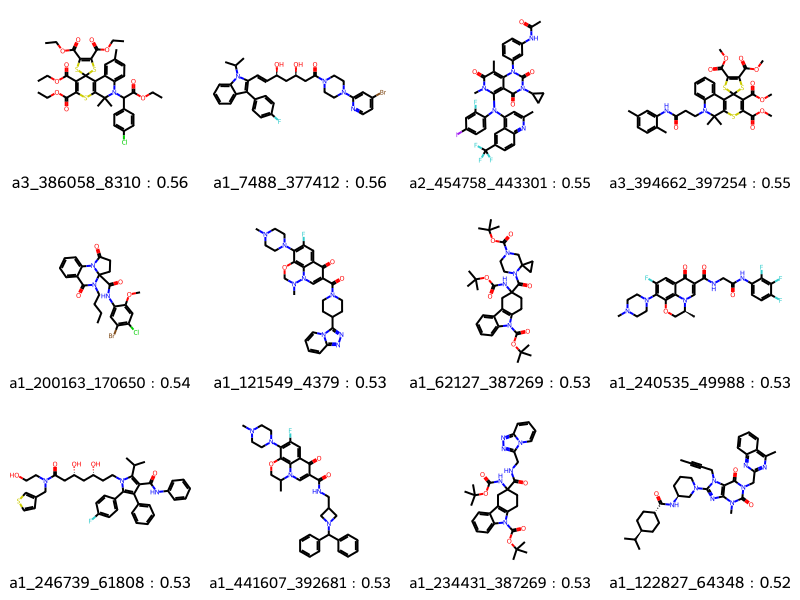

In [16]:
params = rdSynthonSpaceSearch.SynthonSpaceSearchParams()
params.maxHits = 12
params.randomSample = True
params.similarityCutoff = 0.5
params.fragSimilarityAdjuster = 0.0
start = time.perf_counter()
results = synthonspace.FingerprintSearch(qmol, fpgen, params)
hits = results.GetHitMolecules()
hit_names = [f'{m.GetProp("_Name")} : {float(m.GetProp("Similarity")):4.2f}' for m in hits]
print(f"Time to search : {time.perf_counter() - start:4.2f} seconds.")
print(f"Number of hits : {len(hits)}")
print(f"Maximum number of hits possible : {results.GetMaxNumResults}")
Draw.MolsToGridImage(hits[:12], legends=hit_names[:12], molsPerRow=4)

As you can see, the potential number of hits it had to check went down to 690134.

## Working with synthon spaces yourself

In order to use this functionality, you obviously need access to a synthon description of the space you want to search. Due to the size of the files, we don't include a space description with the RDKit itself, so you need to get the data elsewhere.

ChemSpace's FreedomSpace 3.0 and Enamine's REAL are available on request via the links above.  If you just want to experiment then there are small test spaces [here](https://github.com/rdkit/rdkit/tree/master/Code/GraphMol/SynthonSpaceSearch/data).  The [Syntons_5567.csv](https://github.com/rdkit/rdkit/blob/master/Code/GraphMol/SynthonSpaceSearch/data/Syntons_5567.csv) file is a substantial random extract from the FreedomSpace 2023 library.

We don't currently know of any others, but we will update this post as if/when we learn about more. Please leave a comment or get in touch some other way if you have a space you want to share. If you work with a provider of make-on-demand libraries or DELs, ask them if they can provide their libraries in synthon form, and we will add the link above. I (Dave) can work with providers on getting the data in the appropriate format.

## Acknowledgements

Thanks to Greg for pointing me (Dave) at the problem and providing valuable insight and discussions.  
Thanks are also due to Olga Tarkhanova and colleagues at ChemSpace for providing the FreedomSpace 2023 library in synthon and enumerated forms for me to use during development and testing, and also to Yurii Moroz at Enamine for help and discussions.
